# Set-up

In [27]:
# Import modules
import os
import sys
import numpy as np
import pandas as pd
import seqdata as sd

import matplotlib.pyplot as plt
import seaborn as sns
from eugene import plot as pl

sys.path.append("/cellar/users/aklie/data/datasets/PanCancerPeptile/bin/model_training")
from gkmSVM import gkmSvmModule

sys.path.append('/cellar/users/aklie/data/datasets/deAlmeida_DrosophilaS2_UMI-STARR-seq/bin/model_evaluation')
from eval import scatter, auroc, auprc

In [2]:
# Set wd
os.chdir("/cellar/users/aklie/data/datasets/deAlmeida_DrosophilaS2_UMI-STARR-seq")

In [3]:
# Set fold to eval on
date = "2023_12_19"
dataset = "seqdatasets"
model = "gkmSVM"
target_var = "dev"
train_var = "full"

# Set log dir
log_dir = f"models/{date}/{dataset}/{model}/{target_var}/{train_var}"
print(f"Log dir: {log_dir}")

# Metrics
metric = "auroc"

Log dir: models/2023_12_19/seqdatasets/gkmSVM/dev/full


#

In [12]:
df = pd.read_csv("models/2023_12_19/seqdatasets/gkmSVM/crossfold/dev/gkmSVM.cvpred.txt", sep="\t", header=None)
df.columns = ["seq", "SVM_score", "label", "CV_set"]
df.head()


,seq,SVM_score,label,CV_set
0,chr3L:133842-134091(+),0.999620,1,2
1,chr2R:11004809-11005058(-),0.810621,1,8
2,chr3R:6259447-6259696(+),0.667932,1,7
3,chrX:3333056-3333305(-),1.135460,1,10
4,chrX:12263602-12263851(+),1.415290,1,4


In [17]:
outdir = os.path.join(log_dir, "performance")
if not os.path.exists(outdir):
    os.makedirs(outdir)

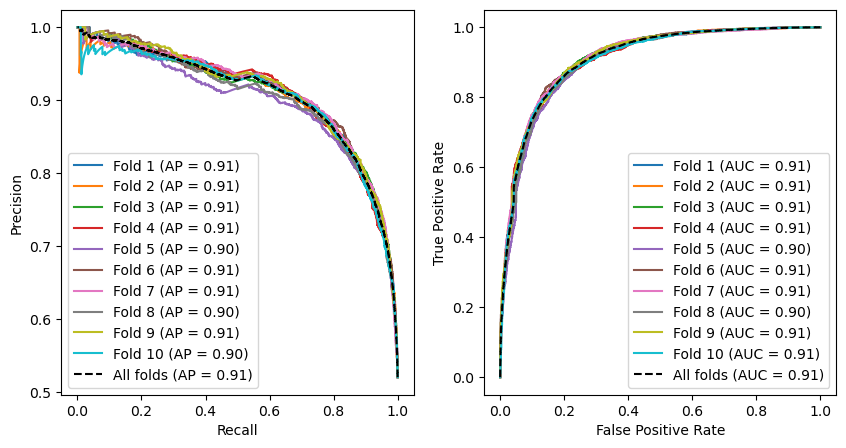

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Group each seq by CV set and plot curves for each fold on same plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for fold, cv in df.groupby("CV_set"):
    # Plot PR curve
    precision, recall, _ = precision_recall_curve(cv["label"], cv["SVM_score"])
    average_precision = average_precision_score(cv["label"], cv["SVM_score"])
    ax[0].plot(recall, precision, label=f"Fold {fold} (AP = {average_precision:.2f})")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(cv["label"], cv["SVM_score"])
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    
# Plot across all folds
precision, recall, _ = precision_recall_curve(df["label"], df["SVM_score"])
average_precision = average_precision_score(df["label"], df["SVM_score"])
ax[0].plot(recall, precision, label=f"All folds (AP = {average_precision:.2f})", color="black", linestyle="--")
fpr, tpr, _ = roc_curve(df["label"], df["SVM_score"])
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label=f"All folds (AUC = {roc_auc:.2f})", color="black", linestyle="--")

ax[0].legend()
ax[1].legend();

fig.savefig(os.path.join(outdir, f"PR_ROC_curves.png"), bbox_inches="tight", dpi=300)

In [ ]:
# Scatter across all folds


# Load test dataset

In [4]:
# Load the dataset
sdata = sd.open_zarr("training/2023_12_19/seqdatasets/deAlmeida22_test.zarr")
sdata.load()

<xarray.Dataset>
Dimensions:                                  (_sequence: 41186, _ohe: 4,
                                              length: 249, _length: 249)
Dimensions without coordinates: _sequence, _ohe, length, _length
Data variables: (12/17)
    Dev_log2_enrichment                      (_sequence) float64 3.418 ... 0....
    Dev_log2_enrichment_quantile_normalized  (_sequence) float64 3.723 ... 0....
    Dev_log2_enrichment_scaled               (_sequence) float64 2.019 ... 0....
    Hk_log2_enrichment                       (_sequence) float64 1.983 ... -1...
    Hk_log2_enrichment_quantile_normalized   (_sequence) float64 2.231 ... -1...
    Hk_log2_enrichment_scaled                (_sequence) float64 1.249 ... -0...
    ...                                       ...
    region                                   (_sequence) <U6 'None' ... 'None'
    seq                                      (_sequence, _length) |S1 b'A' .....
    set                                      (_sequence) <U8 'positive' ... '...
    start                                    (_sequence) <U8 '10574736' ... '...
    strand                                   (_sequence) <U1 '+' '+' ... '-' '-'
    type                                     (_sequence) <U9 'peaks' ... 'None'

# Load model

In [5]:
from gkmSVM import gkmSvmModule

In [29]:
module = gkmSvmModule(
    task="binary_classification",
    kernel_type="gapped-kmer",
    word_length=8,
    informative_columns=5,
)
module

gkmSVM(task=binary_classification, kernel_type=gapped-kmer, word_length=8, informative_columns=5, mismatches=3, gamma=1.0, decay_M=50, half_life=50, reverse_complement=False, regularization_strength=1.0, epsilon=0.001, positive_weight=1.0, cached_mem_size=8000, threads=4, verbosity=2, model_name=gkmSVM)

In [30]:
module.update_after_fit(f"models/2023_12_19/seqdatasets/gkmSVM/dev/full/gkmSVM.model.txt")

# Get predictions

In [31]:
preds = module.predict(sdata["seq"].values)

# Plot performance

In [9]:
outdir = os.path.join(log_dir, "performance")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [25]:
# Grab preds
target_var = ["Dev_log2_enrichment"]
df = sdata[target_var].to_pandas().rename(columns={target_var[0]: "obs"})
df["pred"] = preds
df.to_csv(os.path.join(outdir, "dev_test_preds.csv"), index=False)

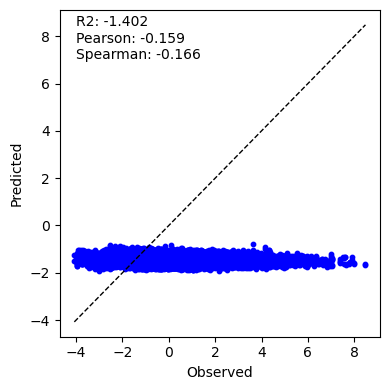

In [28]:
scatter(
    x=df["obs"],
    y=df["pred"],
    rasterized=True,
)

# DONE!

---